In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from IPython.core.display import HTML
import yaml

In [2]:
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import requests
import json
import pycountry
import us

# from statsmodels.iolib.summary2 import summary_col

In [3]:
import re
import subprocess

# use subprocess to run pip install stargazer
try:
    subprocess.check_call(['pip', 'install', 'stargazer'])
except subprocess.CalledProcessError:
    print("Error: Failed to install the 'stargazer' library.")

# Now you can import and use the 'stargazer' library
import stargazer

from stargazer.stargazer import Stargazer, LineLocation


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# read the first dataset

df = pd.read_csv("/Users/cuimengyuan/Desktop/ECO481/final paper/COVID-19_Vaccination_Age_and_Sex_Trends_in_the_United_States__National_and_Jurisdictional.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [5]:
# add age and gender columns
def extract_sex(value):
    if 'Female' in value:
        return 'Female'
    elif 'Male' in value:
        return 'Male'
    else:
        return None

df['Sex'] = df['Demographic_Category'].apply(extract_sex)

def remove_sex(value):
    # Remove 'Male_' or 'Female_' from the beginning of the string
    return re.sub(r'^(Female|Male)_', '', value)

df['Age'] = df['Demographic_Category'].apply(remove_sex)

def replace_underscores(value):
    return value.replace('_', ' ')

df['Age'] = df['Age'].apply(replace_underscores)

df.head()

,Date,Location,Demographic_Category,census,Administered_Dose1,Series_Complete_Yes,Booster_Doses,Second_Booster,Administered_Dose1_pct_agegroup,Series_Complete_Pop_pct_agegroup,Booster_Doses_Vax_pct_agegroup,Second_Booster_Vax_pct_agegroup,Sex,Age
0,2023-05-10,NM,Female_Ages_<5yrs,59296.0,7142.0,3387.0,258.0,NaN,12.0,5.7,7.6,NaN,Female,Ages <5yrs
1,2023-05-10,WV,Female_Ages_<5yrs,45418.0,1573.0,888.0,NaN,NaN,3.5,2.0,NaN,NaN,Female,Ages <5yrs
2,2023-05-10,ME,Ages_25-39_yrs,241973.0,233633.0,198938.0,93609.0,NaN,95.0,82.2,47.1,NaN,None,Ages 25-39 yrs
3,2023-05-10,VA,Ages_25-39_yrs,1772094.0,1660456.0,1370318.0,569099.0,NaN,93.7,77.3,41.5,NaN,None,Ages 25-39 yrs
4,2023-05-10,IL,Female_Ages_25-39_yrs,1291981.0,1085237.0,967492.0,489565.0,NaN,84.0,74.9,50.6,NaN,Female,Ages 25-39 yrs


In [6]:
df = df[~df["Age"].isin(['Age Unknown', 'Sex Unknown', 'Sex Female', 'Sex Male'])]

# add controlled dummy variables - sex and age groups
df["Male"] = np.where(df["Sex"] == "Male", 1, 0)

df["Baby"] = np.where((df["Age"] == "Ages <2yrs") | (df["Age"] == "Ages <5yrs") | (df["Age"] == "Ages 2-4 yrs"), 1, 0)
df["Child"] = np.where(df["Age"] == "Ages 5-11 yrs", 1, 0)
df["Teen"] = np.where(df["Age"] == "Ages 12-17 yrs", 1, 0)
df["YoungAdlt"] = np.where(df["Age"] == "Ages 18-24 yrs", 1, 0)
df["MidAdlt"] = np.where((df["Age"] == "Ages 25-39 yrs") | (df["Age"] == "Ages 25-49 yrs") | (df["Age"] == "Ages 40-49 yrs"), 1, 0)
df["YoungEldr"] = np.where(df["Age"] == "Ages 50-64 yrs", 1, 0)
df["OldEldr"] = np.where((df["Age"] == "Ages 65-74 yrs") | (df["Age"] == "Ages 65+ yrs") | (df["Age"] == "Ages 75+ yrs"), 1, 0)

In [7]:
# convert date and location to month and region dummies
df["Jan"] = np.where(df["Date"] < '02/01/2022 12:00:00 AM', 1, 0)
df["Feb"] = np.where((df["Date"] >= '02/01/2022 12:00:00 AM') & (df["Date"] < '03/01/2022 12:00:00 AM'), 1, 0)
df["Mar"] = np.where((df["Date"] >= '03/01/2022 12:00:00 AM') & (df["Date"] < '04/01/2022 12:00:00 AM'), 1, 0)
df["Apr"] = np.where((df["Date"] >= '04/01/2022 12:00:00 AM') & (df["Date"] < '05/01/2022 12:00:00 AM'), 1, 0)
df["May"] = np.where((df["Date"] >= '05/01/2022 12:00:00 AM') & (df["Date"] < '06/01/2022 12:00:00 AM'), 1, 0)
df["Jun"] = np.where((df["Date"] >= '06/01/2022 12:00:00 AM') & (df["Date"] < '07/01/2022 12:00:00 AM'), 1, 0)
df["Jul"] = np.where((df["Date"] >= '07/01/2022 12:00:00 AM') & (df["Date"] < '08/01/2022 12:00:00 AM'), 1, 0)
df["Aug"] = np.where((df["Date"] >= '08/01/2022 12:00:00 AM') & (df["Date"] < '09/01/2022 12:00:00 AM'), 1, 0)
df["Sep"] = np.where((df["Date"] >= '09/01/2022 12:00:00 AM') & (df["Date"] < '10/01/2022 12:00:00 AM'), 1, 0)
df["Oct"] = np.where((df["Date"] >= '10/01/2022 12:00:00 AM') & (df["Date"] < '11/01/2022 12:00:00 AM'), 1, 0)
df["Nov"] = np.where((df["Date"] >= '11/01/2022 12:00:00 AM') & (df["Date"] < '12/01/2022 12:00:00 AM'), 1, 0)
df["Dec"] = np.where((df["Date"] >= '12/01/2022 12:00:00 AM') & (df["Date"] < '01/01/2023 12:00:00 AM'), 1, 0)

def geographic(state):
    if state in ["ME", "NH", "VT", "MA", "RI", "CT", "NY", "NJ", "PA", "DE", "MD", "DC", "VA", "WV", "NC", "SC", "GA", "FL"]:
        return "Eastern"
    elif state in ["AL", "MS", "LA", "AR", "TN", "KY", "OH", "MI", "IN", "IL", "WI", "MN", "IA", "MO", "ND", "SD", "NE", "KS", "OK", "TX"]:
        return "Central"
    elif state in ["CO", "WY", "MT", "ID", "UT", "NV", "AZ", "NM", "WA", "OR", "CA", "AK", "HI"]: 
        return "Western"
    else:
        return "Unknown"
df["Region"] = df["Location"].apply(geographic)

df["Eastern"] = np.where(df["Region"] == "Eastern", 1, 0)
df["Western"] = np.where(df["Region"] == "Western", 1, 0)
df["Central"] = np.where(df["Region"] == "Central", 1, 0)

In [8]:
# read another dataset
df1 = pd.read_csv("/Users/cuimengyuan/Desktop/ECO481/final paper/United_States_COVID-19_Community_Levels_by_County.csv")

df1 = df1.drop(columns = ['county', 'county_fips', 'county_population', 'health_service_area_number', 'covid-19_community_level'])
df1['date_updated'] = pd.to_datetime(df1['date_updated'])

# convert state names into abbreviations
statemap = {state.name: state.abbr for state in us.states.STATES}
df1['state'] = df1['state'].map(statemap)

# only select data from Feb 24 2022 to Dec 31 2022
df1 = df1[df1['date_updated'] < '01/01/2023 12:00:00 AM']

In [9]:
# calculate rates
df1['hospital'] = df1['covid_hospital_admissions_per_100k'] / 100000 * 100
df1['case'] = df1['covid_cases_per_100k'] / 100000 * 100

# set groupby indicator
df1['interact'] = df1['state'] + " " + df1['date_updated'].dt.strftime('%m/%d/%Y %I:%M:%S %p')

# convert county level to state/territory level
avg = df1[['interact', 'hospital', 'case']].groupby(by="interact").mean().reset_index()
avg.rename(columns={'hospital': 'avg_hospital', 'case': 'avg_case'}, inplace=True)

df1 = pd.merge(df1, avg, on = 'interact', how = 'left')
df1.head()

,state,health_service_area,health_service_area_population,covid_inpatient_bed_utilization,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated,hospital,case,interact,avg_hospital,avg_case
0,WI,"Marathon (Wausau), WI - Wood, WI",291401.0,4.7,13.4,177.58,2022-08-18,0.0134,0.17758,WI 08/18/2022 12:00:00 AM,0.011208,0.20465
1,WI,"Sheboygan (Sheboygan), WI - Manitowoc, WI",244410.0,3.4,9.8,169.66,2022-08-18,0.0098,0.16966,WI 08/18/2022 12:00:00 AM,0.011208,0.20465
2,WI,"Marathon (Wausau), WI - Wood, WI",291401.0,4.7,13.4,209.30,2022-08-18,0.0134,0.20930,WI 08/18/2022 12:00:00 AM,0.011208,0.20465
3,WI,"La Crosse (La Crosse), WI - Monroe, WI",257027.0,3.9,15.6,216.20,2022-08-18,0.0156,0.21620,WI 08/18/2022 12:00:00 AM,0.011208,0.20465
4,WI,"Portage, WI",70772.0,5.9,7.1,217.60,2022-08-18,0.0071,0.21760,WI 08/18/2022 12:00:00 AM,0.011208,0.20465


In [10]:
# merge two datasets
ve = df1[['state', 'covid_inpatient_bed_utilization', 'date_updated', 'hospital', 'case', 'avg_hospital', 'avg_case']]

data = pd.merge(df, ve, left_on = ['Date', 'Location'], right_on = ['date_updated', 'state'], how = 'inner')
data = data.drop(columns=['date_updated', 'state'])

# drop missing values
data = data.dropna(subset=['Administered_Dose1_pct_agegroup', 'Series_Complete_Pop_pct_agegroup', 'Booster_Doses_Vax_pct_agegroup', 'avg_case', 'avg_hospital', 'covid_inpatient_bed_utilization', 'Sex', 'Date', 'Location'])

data.head()

,Date,Location,Demographic_Category,census,Administered_Dose1,Series_Complete_Yes,Booster_Doses,Second_Booster,Administered_Dose1_pct_agegroup,Series_Complete_Pop_pct_agegroup,...,Dec,Region,Eastern,Western,Central,covid_inpatient_bed_utilization,hospital,case,avg_hospital,avg_case
0,2022-12-29,MD,Male_Ages_25-49_yrs,980946.0,908024.0,774494.0,353695.0,NaN,92.6,79.0,...,1,Eastern,1,0,0,6.3,0.0124,0.08847,0.010837,0.085227
1,2022-12-29,MD,Male_Ages_25-49_yrs,980946.0,908024.0,774494.0,353695.0,NaN,92.6,79.0,...,1,Eastern,1,0,0,5.2,0.0076,0.07821,0.010837,0.085227
2,2022-12-29,MD,Male_Ages_25-49_yrs,980946.0,908024.0,774494.0,353695.0,NaN,92.6,79.0,...,1,Eastern,1,0,0,4.4,0.0119,0.07927,0.010837,0.085227
3,2022-12-29,MD,Male_Ages_25-49_yrs,980946.0,908024.0,774494.0,353695.0,NaN,92.6,79.0,...,1,Eastern,1,0,0,6.3,0.0124,0.10040,0.010837,0.085227
4,2022-12-29,MD,Male_Ages_25-49_yrs,980946.0,908024.0,774494.0,353695.0,NaN,92.6,79.0,...,1,Eastern,1,0,0,7.8,0.0115,0.11277,0.010837,0.085227


In [11]:
# create a summary statistics for the main variables
summary_stats = {'First Dose': data['Administered_Dose1_pct_agegroup'].describe(),
                 'Series Completion': data['Series_Complete_Pop_pct_agegroup'].describe(),
                 'Booster Dose': data['Booster_Doses_Vax_pct_agegroup'].describe(),
                 'Covid Case': data['avg_case'].describe(),
                 'Hospital Visit': data['avg_hospital'].describe(),
                 'Bed Utilize': data['covid_inpatient_bed_utilization'].describe(),
                 'Sex': data['Sex'].describe(),
                 'Age Group': data['Age'].describe(),
                 'States': data['Location'].describe(),
                 'Time': data['Date'].describe()}

sum = pd.DataFrame(summary_stats).T

numeric = sum.columns[sum.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))]
sum[numeric] = sum[numeric].applymap("{:.2f}".format)

sum = sum.rename(columns={'count': 'No. Observations', 'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Min', 'max': 'Max'})
sum = sum.drop(['freq', 'top', 'unique'], axis=1, errors='ignore')

# add a title to the summary statistic table
sum.style.set_caption('Table 1 - Summary Statistics.')

,25%,50%,75%,No. Observations,Max,Mean,Min,Standard Deviation
First Dose,66.500000,82.200000,95.000000,2773714.000000,95.000000,77.006998,2.300000,19.912905
Series Completion,56.400000,71.300000,86.000000,2773714.000000,95.000000,68.609722,1.100000,20.496350
Booster Dose,28.800000,43.500000,65.200000,2773714.000000,91.200000,45.408044,0.000000,21.543030
Covid Case,0.066166,0.110478,0.172524,2773714.000000,2.351971,0.128988,0.000000,0.089697
Hospital Visit,0.004759,0.007661,0.010473,2773714.000000,0.027247,0.007892,0.000745,0.003992
Bed Utilize,1.400000,2.800000,4.600000,2773714.000000,36.000000,3.282378,0.000000,2.546367
Sex,nan,nan,nan,2773714,nan,nan,nan,nan
Age Group,nan,nan,nan,2773714,nan,nan,nan,nan
States,nan,nan,nan,2773714,nan,nan,nan,nan
Time,2022-05-19 00:00:00,2022-08-04 00:00:00,2022-10-20 00:00:00,2773714,2022-12-29 00:00:00,2022-08-01 21:30:20.980533760,2022-02-24 00:00:00,nan


In [12]:
# save results
Path('results').mkdir(parents=True, exist_ok=True)

output = {
    'summary': sum
}

# save the dictionary as a YAML file
with open('results/summary.yaml', 'w') as file:
    yaml.dump(output, file)

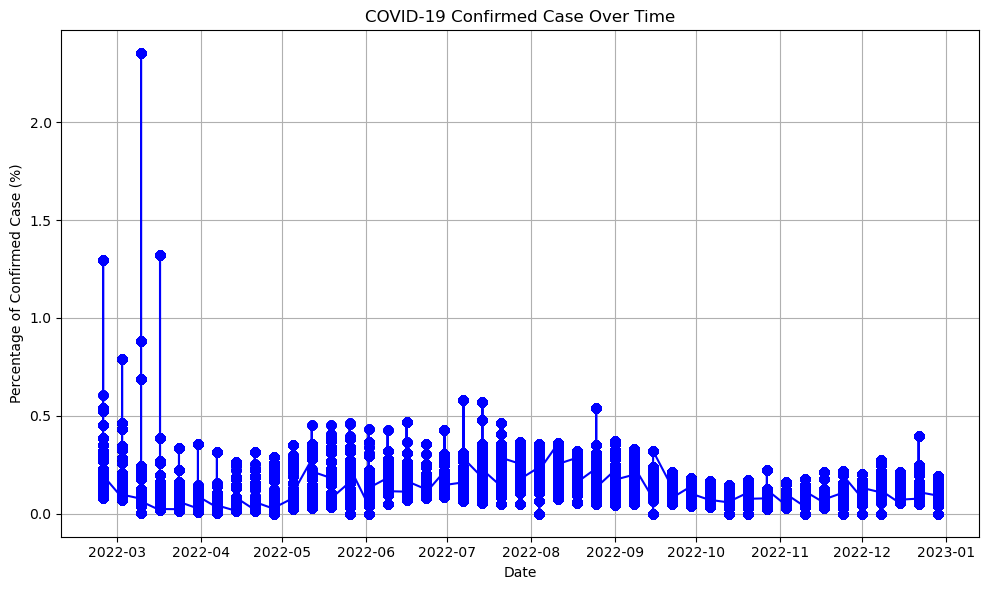

In [19]:
# plot changes over time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['avg_case'], marker='o', linestyle='-', color='b')
plt.title('COVID-19 Confirmed Case Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Confirmed Case (%)')
plt.grid(True)
plt.tight_layout()

plt.show()

plt.savefig('results/confirmed_case_change.png')

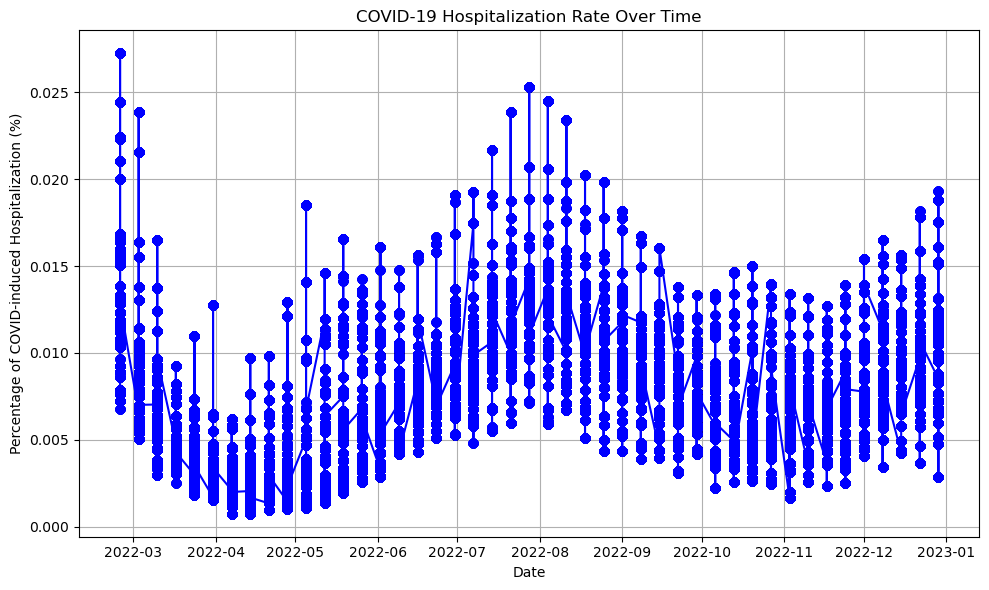

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['avg_hospital'], marker='o', linestyle='-', color='b')
plt.title('COVID-19 Hospitalization Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of COVID-induced Hospitalization (%)')
plt.grid(True)
plt.tight_layout()

plt.show()

plt.savefig('results/hospitalization_rate_change.png')

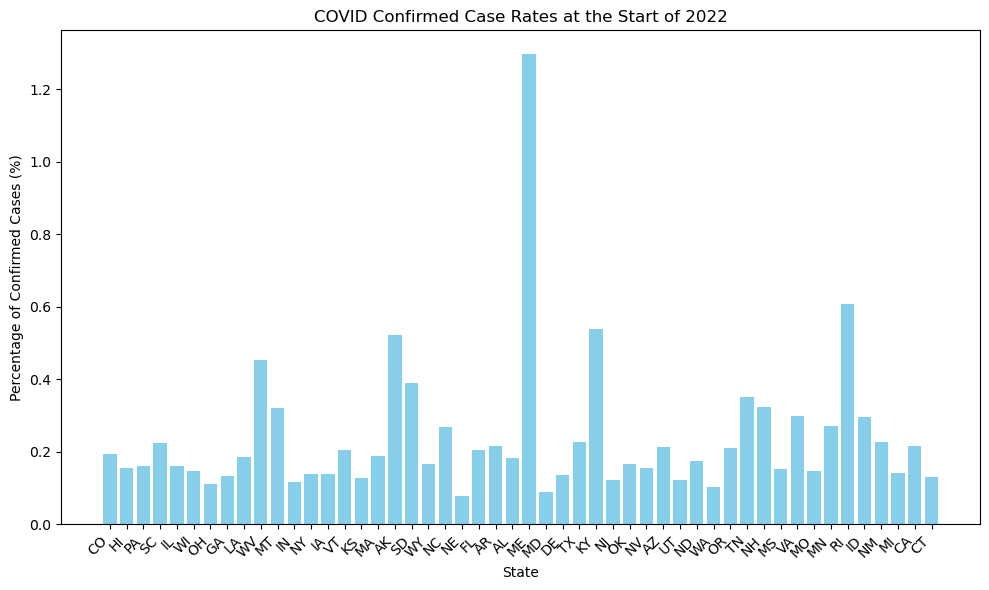

<Figure size 640x480 with 0 Axes>

In [24]:
# plot vaccine effectiveness at the start of 2022
start_2022 = data[data['Date'] == '2022-02-24 00:00:00']

plt.figure(figsize=(10, 6))
plt.bar(start_2022['Location'], start_2022['avg_case'], color='skyblue')

plt.title('COVID Confirmed Case Rates at the Start of 2022')
plt.xlabel('State')
plt.ylabel('Percentage of Confirmed Cases (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state labels for better readability
plt.tight_layout()

plt.show()

plt.savefig('results/confirmed_case_start_2022.png')

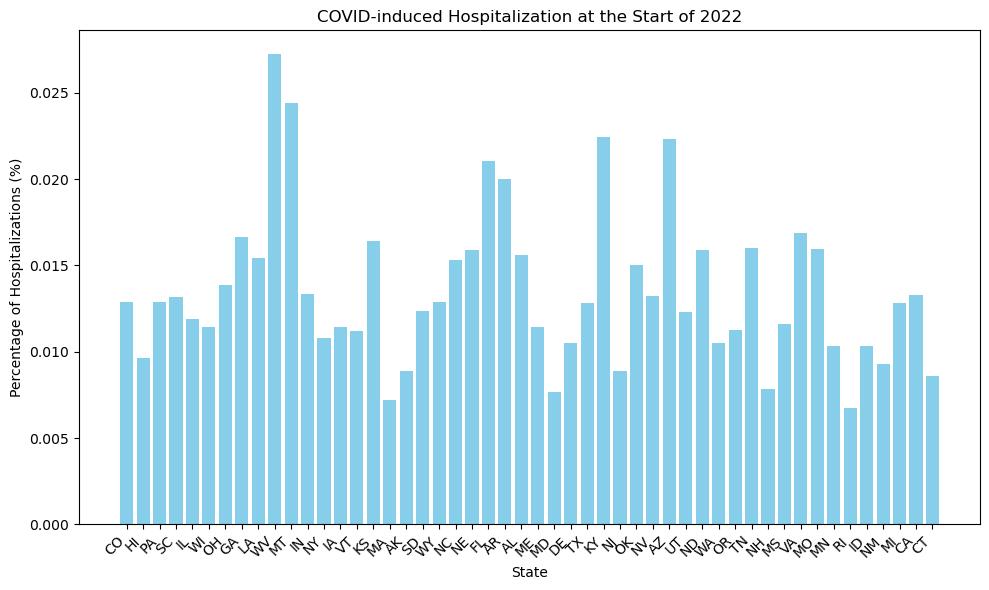

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(start_2022['Location'], start_2022['avg_hospital'], color='blue')

plt.title('COVID-induced Hospitalization at the Start of 2022')
plt.xlabel('State')
plt.ylabel('Percentage of Hospitalizations (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state labels for better readability
plt.tight_layout()

plt.show()

plt.savefig('results/hospitalization_rate_start_2022.png')

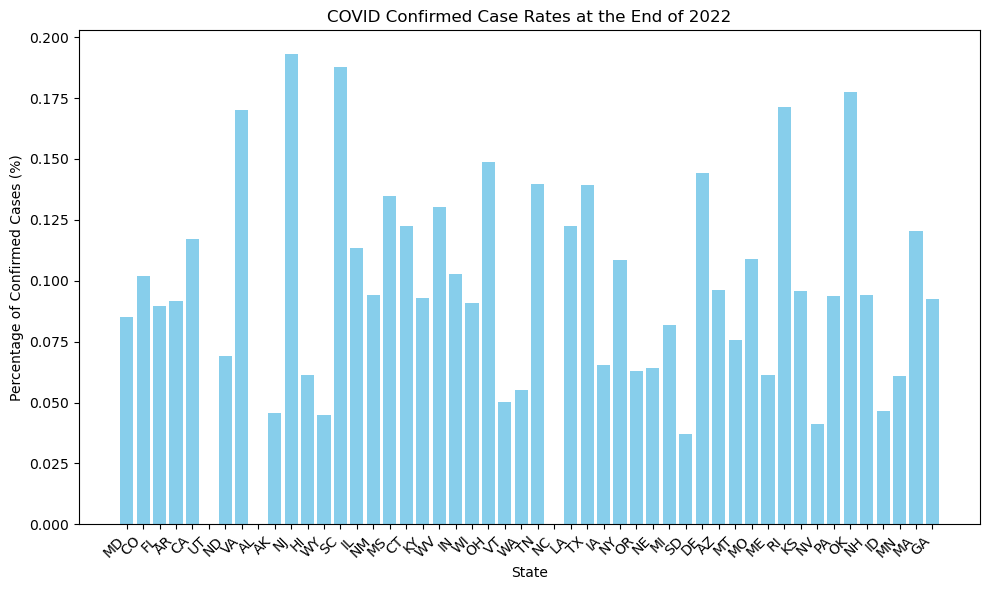

In [21]:
# plot vaccine effectiveness at the end of 2022
end_2022 = data[data['Date'] == '2022-12-29 00:00:00']

plt.figure(figsize=(10, 6))
plt.bar(end_2022['Location'], end_2022['avg_case'], color='skyblue')

plt.title('COVID Confirmed Case Rates at the End of 2022')
plt.xlabel('State')
plt.ylabel('Percentage of Confirmed Cases (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state labels for better readability
plt.tight_layout()

plt.show()

plt.savefig('results/confirmed_case_end_2022.png')

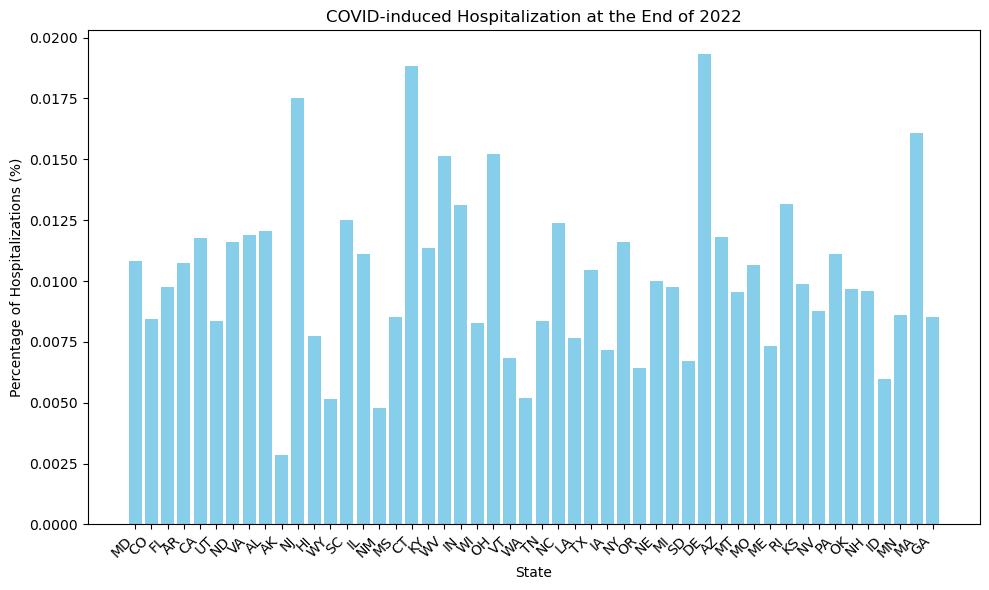

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(end_2022['Location'], end_2022['avg_hospital'], color='blue')

plt.title('COVID-induced Hospitalization at the End of 2022')
plt.xlabel('State')
plt.ylabel('Percentage of Hospitalizations (%)')
plt.xticks(rotation=45, ha='right')  # Rotate state labels for better readability
plt.tight_layout()

plt.show()

plt.savefig('results/hospitalization_rate_end_2022.png')

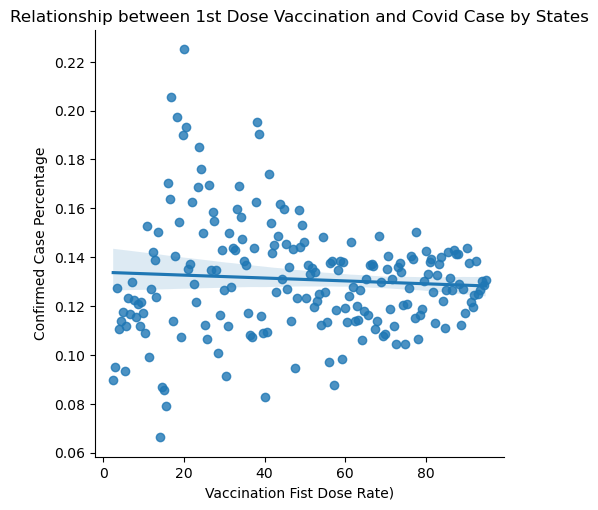

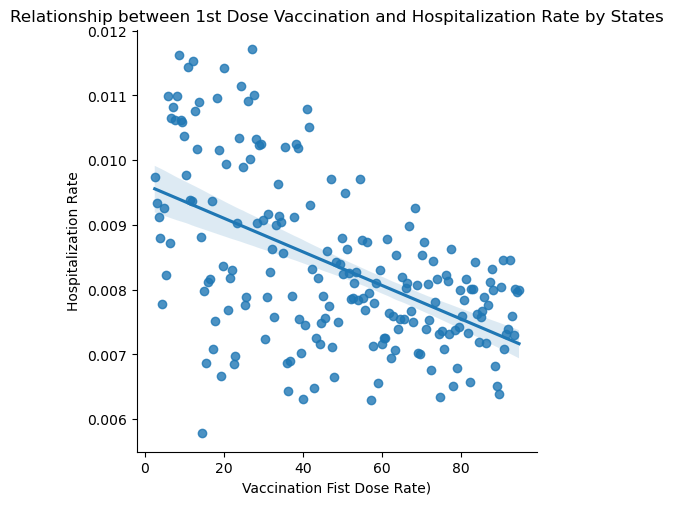

In [13]:
# separate my 1st x-variable into 200 bins
df2 = data.copy()
df2['firstdose'] = pd.cut(df2['Administered_Dose1_pct_agegroup'], 200)
df2 = df2[['firstdose', 'avg_case', 'avg_hospital']].groupby(by='firstdose').mean().reset_index()
df2['binmean'] = df2.firstdose.apply(lambda x: x.mid)

# create bin scatterplot with regression line for 1st x, 1st y
sns.lmplot(data = df2, x = "binmean", y = "avg_case")
plt.xlabel("Vaccination Fist Dose Rate)")
plt.ylabel("Confirmed Case Percentage")
plt.title("Relationship between 1st Dose Vaccination and Covid Case by States")
plt.show()
plt.savefig('results/1st_dose_confirmed_case.png')

# create another binscatter for 1st x, 2nd y
sns.lmplot(data = df2, x = "binmean", y = "avg_hospital")
plt.xlabel("Vaccination Fist Dose Rate)")
plt.ylabel("Hospitalization Rate")
plt.title("Relationship between 1st Dose Vaccination and Hospitalization Rate by States")
plt.show()
plt.savefig('results/1st_dose_hospitalization.png')

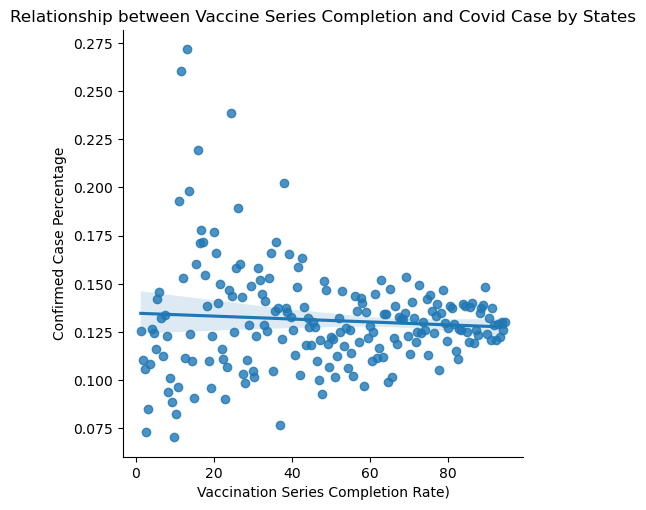

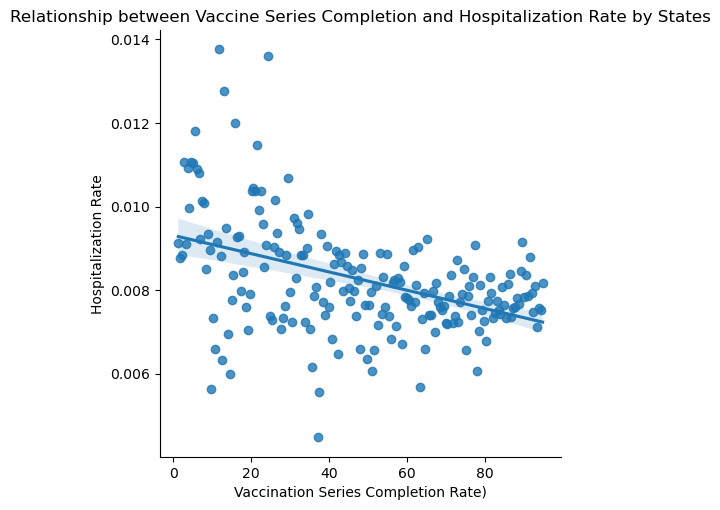

In [14]:
# separate my 2nd x-variable into 200 bins
df3 = data.copy()
df3['series'] = pd.cut(df3['Series_Complete_Pop_pct_agegroup'], 200)
df3 = df3[['series', 'avg_case', 'avg_hospital']].groupby(by='series').mean().reset_index()
df3['binned'] = df3.series.apply(lambda x: x.mid)

# create bin scatterplot with regression line for 2nd x, 1st y
sns.lmplot(data = df3, x = "binned", y = "avg_case")
plt.xlabel("Vaccination Series Completion Rate)")
plt.ylabel("Confirmed Case Percentage")
plt.title("Relationship between Vaccine Series Completion and Covid Case by States")
plt.show()
plt.savefig('results/series_complete_confirmed_case.png')

# create bin scatterplot for 2nd x, 2nd y
sns.lmplot(data = df3, x = "binned", y = "avg_hospital")
plt.xlabel("Vaccination Series Completion Rate)")
plt.ylabel("Hospitalization Rate")
plt.title("Relationship between Vaccine Series Completion and Hospitalization Rate by States")
plt.show()
plt.savefig('results/series_complete_hospitalization.png')

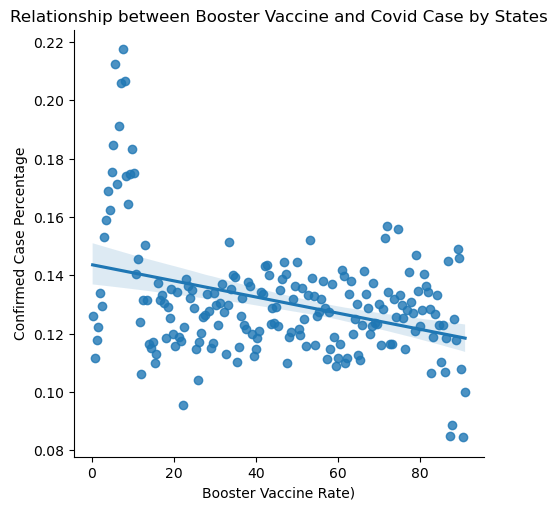

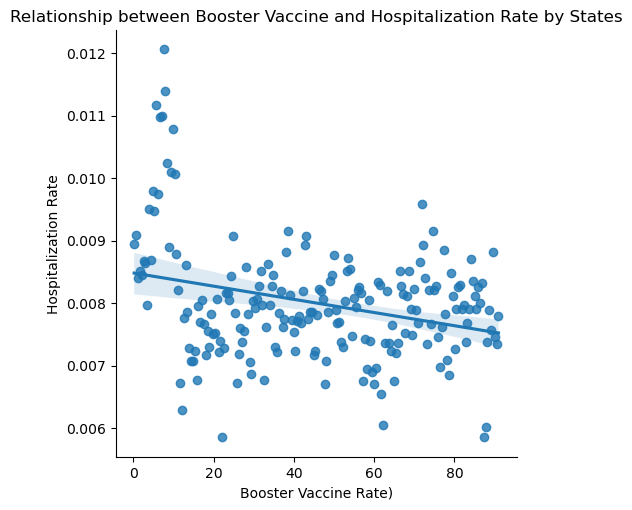

In [15]:
# separate my 3rd x-variable into 200 bins
df4 = data.copy()
df4['booster'] = pd.cut(df4['Booster_Doses_Vax_pct_agegroup'], 200)
df4 = df4[['booster', 'avg_case', 'avg_hospital']].groupby(by='booster').mean().reset_index()
df4['bin'] = df4.booster.apply(lambda x: x.mid)

# create bin scatterplot with regression line for 3rd x, 1st y
sns.lmplot(data = df4, x = "bin", y = "avg_case")
plt.xlabel("Booster Vaccine Rate)")
plt.ylabel("Confirmed Case Percentage")
plt.title("Relationship between Booster Vaccine and Covid Case by States")
plt.show()
plt.savefig('results/booster_confirmed_case.png')

# create bin scatterplot for 3rd x, 2nd y
sns.lmplot(data = df4, x = "bin", y = "avg_hospital")
plt.xlabel("Booster Vaccine Rate)")
plt.ylabel("Hospitalization Rate")
plt.title("Relationship between Booster Vaccine and Hospitalization Rate by States")
plt.show()
plt.savefig('results/booster_hospitalization.png')

In [16]:
# linear regression
data['const'] = 1

# define different sets of X-variables in each regression
X1 = ['const', 'Administered_Dose1_pct_agegroup', 'Series_Complete_Pop_pct_agegroup', 'Booster_Doses_Vax_pct_agegroup']
# in X2, the omitted variable is female, baby?
X2 = ['const', 'Administered_Dose1_pct_agegroup', 'Series_Complete_Pop_pct_agegroup', 'Booster_Doses_Vax_pct_agegroup', 'Male', 'Child', 'Teen', 'YoungAdlt', 'MidAdlt', 'YoungEldr', 'OldEldr']
# add state and time effects, omitted western, december
X3 = ['const', 'Administered_Dose1_pct_agegroup', 'Series_Complete_Pop_pct_agegroup', 'Booster_Doses_Vax_pct_agegroup', 'Male', 'Child', 'Teen', 'YoungAdlt', 'MidAdlt', 'YoungEldr', 'OldEldr', 'Eastern', 'Central', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

# estimate the regressions for each set of variables
reg1 = sm.OLS(data['avg_case'], data[X1]).fit()
reg2 = sm.OLS(data['avg_case'], data[X2]).fit()
reg3 = sm.OLS(data['avg_case'], data[X3]).fit()

reg4 = sm.OLS(data['avg_hospital'], data[X1]).fit()
reg5 = sm.OLS(data['avg_hospital'], data[X2]).fit()
reg6 = sm.OLS(data['avg_hospital'], data[X3]).fit()

In [17]:
# use stargazer to generate regression outputs
stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6])
stargazer.title('Table 2 - Regression Outputs.')

# rename the models
stargazer.custom_columns(['Case', 'Case w Demo', 'Case w Time/Plce', 'Hospital', 'Hsptl w Demo', 'Hsptl w Time/Plce'], [1, 1, 1, 1, 1, 1])

# set variables order, rename some variables
stargazer.covariate_order(['const', 'Administered_Dose1_pct_agegroup', 'Series_Complete_Pop_pct_agegroup', 'Booster_Doses_Vax_pct_agegroup'])
stargazer.rename_covariates({'const': 'Constant',
                               'Administered_Dose1_pct_agegroup': '1st Dose Received',
                               'Series_Complete_Pop_pct_agegroup': 'Series Complete',
                               'Booster_Doses_Vax_pct_agegroup': 'Booster Received'})

# add lines to indicate controlled variables
stargazer.add_line('Sex', ['No', 'Yes', 'Yes', 'No', 'Yes','Yes'], LineLocation.FOOTER_TOP)
stargazer.add_line('Age Group', ['No', 'Yes', 'Yes', 'No', 'Yes', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.add_line('Place', ['No', 'No', 'Yes', 'No', 'No', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.add_line('Time', ['No', 'No', 'Yes', 'No', 'No', 'Yes'], LineLocation.FOOTER_TOP)

# show two decimal points in the output
stargazer.significant_digits(4)
stargazer.show_degrees_of_freedom(False)

HTML(stargazer.render_html())

In [18]:
html_table = stargazer.render_html()

yaml_data = {
    'html_table': html_table
}

# save the output as a YAML file
with open('results/regression_table.yaml', 'w') as file:
    yaml.dump(yaml_data, file)